# Lab 11 Dynamical Friction

Starting from the Homework 7 Solutions, add Dynamical Friction to better match the simulation data. 



In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import the CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass
# import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

1. Add a new variable to the initializer for the class,  `self.M33halo`,  that defines M33's halo mass.

2. Add a new varaible to the initialization of the class, `self.Vc`, the circular speed at large radii from M31. Let's assume this is flat at $V_c$ = 200 km/s in the M31 halo outskirts.  or 230 from Homework 5

3. Add a function called `DynamicalFriction` that takes as inputs (Msat,r,v), and computes the acceleration, assuming an isothermal sphere profile for the dark matter halo of M31.

$ {\bf a} =  -0.428 \frac{GM_{\rm sat} \rm{ln}(\Lambda)}{r^2} \frac{\bf v}{v} $ 

Where the ${\rm ln}(\Lambda)$ is the Coulomb logairthm 

$\Lambda = \frac{bmax}{bmin} $

$bmax$ = the current separation between M31 and M33 and 

$bmin = \frac{GM_{sat}}{V_c^2}$

4. Include this function in `M33Accel`.  Note that it will require a new input, v (velocity vector). This must be accounted for also when M33Accel is called in LeapFrog 

5. If the orbit doesn't match well. Add a fudge factor (`self.fudge`) that is some fraction of 1 to decrease the strength of the dynamical friction term. 

6. What other reasons might there be for why the orbits don't match?

In [9]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        """ Initialize the class with the current properties of M33 
        input: filename, string denoting the name of the file in which the output orbit will be stored """
        
        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # store the output file name
        self.filename = filename
        
        # get the current pos/vel of M33 relative to M31
        M33_COM = CenterOfMass("M33_000.txt", 2)
        self.r0 = M33_COM.COM_P(0.1, 4)  # equivalently could have set self.x self.y self.z to each component.
        self.v0 = M33_COM.COM_V(self.r0[0], self.r0[1],self.r0[2]).value
        self.r0 = self.r0.value
        
        M31_COM = CenterOfMass("M31_000.txt", 2)
        M31_r0 = M31_COM.COM_P(0.1, 2)
        self.r0 -= M31_r0.value #  subtract out the M31 COM Position from the previously defined values
        self.v0 -= M31_COM.COM_V(M31_r0[0], M31_r0[1], M31_r0[2]).value   
        # subtract out the M31 COM velocity from the previously defined values
        
        # get the mass of each component in M31 
        # disk
        self.rdisk = 5.0 # set the scale length 
        self.Mdisk = ComponentMass("M31_000.txt", 2)*1e12
        
        # bulge
        self.rbulge = 1.0 # set the bulge scale length
        self.Mbulge = ComponentMass("M31_000.txt", 3)*1e12
        
        # Halo
        self.rhalo = 61.58 # use the Hernquist scale length (a) computed in HW5
        self.Mhalo = ComponentMass("M31_000.txt", 1)*1e12
      
    
        ### ADD M33 HALO MASS HERE #### 
        self.M33halo = ComponentMass('M33_000.txt',1)*1e12
    
        ### ADD M31 CIRCULAR SPEED HERE ### 
        self.Vc = 230 #km/s
        
        ### Fudge factor ## 
        self.fudge = 0.5
    
    
    def HenquistAccel(self, M, r_a, r):
        """ Compute the Hernquist profile acceleration 
        Inputs :  M the Hernquist mass (Msun)
                r_a the Hernquist scale length (kpc)
                r the position vector [ x, y, z]
        Returns:  the Acceleration vector for a Hernquist profile [Ax, Ay, Az]"""
        
        # follow the formula in the HW instructions
        r_mag = np.sqrt(np.sum(r**2))
        return -self.G * M / (r_mag * (r_a + r_mag)**2) * r
    
    def MiyamotoNagaiAccel(self, M, rd, r):
        """ Compute the Miyamoto-Nagai profile acceleration
        Inputs:  M  the disk mass (Msun)
                rd the disk scale length (kpc)
                r the position vector [ x, y, z]
        Returns: the Acceleration vector for a Miyamoto-Nagai profile [Ax, Ay, Az] """
        
        # follow the formula in the HW instructions
        R2 = np.sum(r[:2]**2)
        zd = rd / 5.0
        B = rd + np.sqrt(r[2]**2 + zd**2)
        return -self.G * M / (R2 + B**2)**1.5 * r * np.array([1, 1, B/(B-rd)]) 
        # the np.array allows for a different value for the z component of the acceleration
  

    ########### ADD Dynamical Friction Term Here ##################
    def DynamicalFriction(self,Msat,Vc,r,v):
        '''Function that computes dynamical friction on the satellite galaxy.
        INPUTS: Msat = Mass of satellite (in Msun); Vc = circular speed at large radii from M31.
        r = position vector of M33.
        v = veloctiy vector of M33.
        RETURNS: deceleration vector due to dynamical friction.
        a = 0.428 G Msat ln(lambda) /rmag^2 v/vmag'''
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        vmag = np.sqrt(v[0]**2+v[1]**2+v[2]**2)
        # defining terms in Coulomb logarithm: ln(lambda)
        bmax = rmag
        bmin = self.G*Msat/Vc**2
        Coulomb = np.log(bmax/bmin)
        
        return -0.428*self.G*Msat*Coulomb/rmag**2*v/vmag*self.fudge
    
    
        
    ##### ADD v to M31Accel input #### 
    def M31Accel(self,r,v):
        """ Compute the total acceleration from M31
        Input: r the position vector [ x, y, z]
               v the velocity vector[vx,vy,vz]
        Returns: A vector for the total acceleration (halo+ bulge+ disk) [ Ax, Ay, Az]"""
        
        ###### ADD DYNAMICAL FRICTION HERE
        return self.HenquistAccel(self.Mhalo, self.rhalo, r) \
             + self.HenquistAccel(self.Mbulge, self.rbulge, r) \
             + self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r) \
             + self.DynamicalFriction(self.M33halo,self.Vc,r,v)
    
    
    def LeapFrog(self, dt, r, v):
        """ perform one step Leap Frog integration for M33
        Input: dt time step in Gyr
            r the current position vector [ x, y, z] 
            v the currentvelocity vector [ vx, vy, vz]
        Returns:  Advances the position and velocity vectors by one timestep """
        
        # predict the position at the next half timestep
        rhalf = r + v * dt / 2.0
        
        # compute the velocity at the next timestep
        ##### ADD v to M31Accel ### 
        vnext = v + self.M31Accel(rhalf,v) * dt
        
        # compute the position at the next timestep
        rnext = r + (vnext+v)/2.0 * dt 
        
        return rnext, vnext
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ Compute the orbit of M33 using the LeapFrog Scheme
        Input:  t0 the current time in Gyr
                dt the time step in Gyr
                tmax the final time in Gyr
        Returns: Generates a file with the original filename given when the class was initialized that stores
                the output of the orbit."""
        
        # initialize the time, counter, and the orbit array
        t = t0
        i = 1
        orbit = np.zeros([int(tmax/dt)+2, 7])
        
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        
        # start the integration
        while (t < tmax):
            # move forward the time by one timestep
            t += dt
            orbit[i, 0] = t
            # integrate the position and velocity using the LeapFrog scheme
            orbit[i, 1:4], orbit[i, 4:] = \
                self.LeapFrog(dt, orbit[i-1, 1:4], orbit[i-1, 4:])
            
            i += 1 # update counter
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        

In [10]:
M33 = M33AnalyticOrbit("M33AnalyticOrbit.txt")
M33.OrbitIntegration(0, 0.1, 10.)

In [11]:
orbit_type = np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])

# Read in Orbit of M33 relative to M31
M33Orbit = np.loadtxt("M33AnalyticOrbit.txt", dtype=orbit_type)

# Read in Orbit of M33 relative to M31 Old, from Homework 7
M33Orbit_Hmwk7 = np.loadtxt("M33AnalyticOrbit_Hmwk7.txt", dtype=orbit_type)


# Read in simulation Orbit from Homework 6
M33SimOrbit = np.genfromtxt('Orbit_M33.txt', dtype = orbit_type)
M31SimOrbit = np.genfromtxt('Orbit_M31.txt', dtype = orbit_type)

In [12]:
def relative_mag(orbit1, orbit2): # calculate relative sep or vel
    return np.sqrt(np.sum((orbit1['r'] - orbit2['r'])**2, axis=1)), \
           np.sqrt(np.sum((orbit1['v'] - orbit2['v'])**2, axis=1))
def vector_mag(orbit):
    return np.sqrt(np.sum(orbit['r']**2, axis=1)), \
           np.sqrt(np.sum(orbit['v']**2, axis=1))

In [13]:
# Determine the magnitude of the position and velocities 

# of MW and M31
M31_M33_R, M31_M33_V = vector_mag(M33Orbit)

# of MW and M31 : Homework 7 
M31_M33_R_Hmwk7, M31_M33_V_Hmwk7 = vector_mag(M33Orbit_Hmwk7)


# of M33 and M31
M31_M33_SimR, M31_M33_SimV = relative_mag(M31SimOrbit, M33SimOrbit)

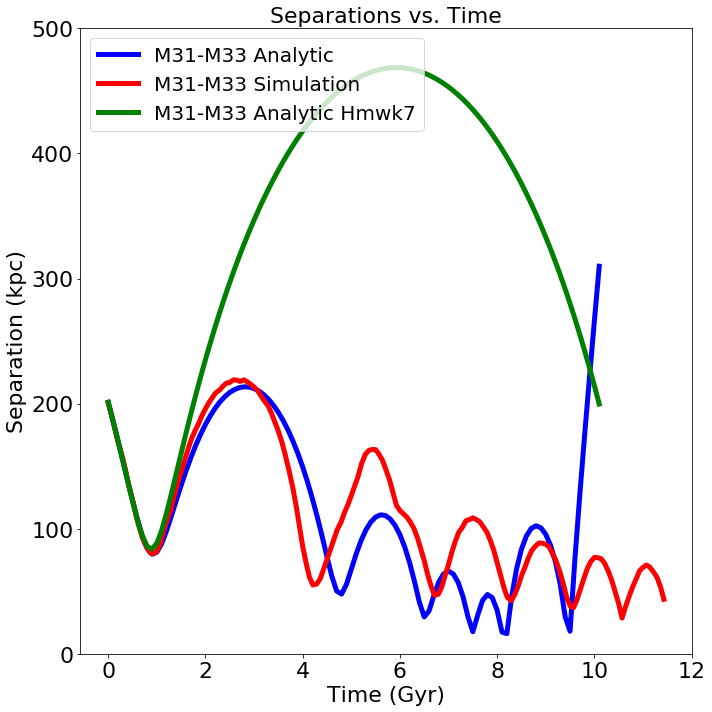

In [14]:
# Plot the orbital separations of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(10, 10))

# Plot the analytical separation of M31 and M33
ax.plot(M33Orbit['t'], M31_M33_R, 'b', lw=5, label='M31-M33 Analytic')

# Plot the simulated separation of M31 and M33
ax.plot(M33SimOrbit['t'], M31_M33_SimR, 'r', lw=5, label='M31-M33 Simulation')

# Plot the simulated separation of M31 and M33 from Homework 7
ax.plot(M33Orbit_Hmwk7['t'], M31_M33_R_Hmwk7, 'g', lw=5, label='M31-M33 Analytic Hmwk7')


# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)
ax.set_title("Separations vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

plt.ylim(0, 500)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_M33_R.pdf')

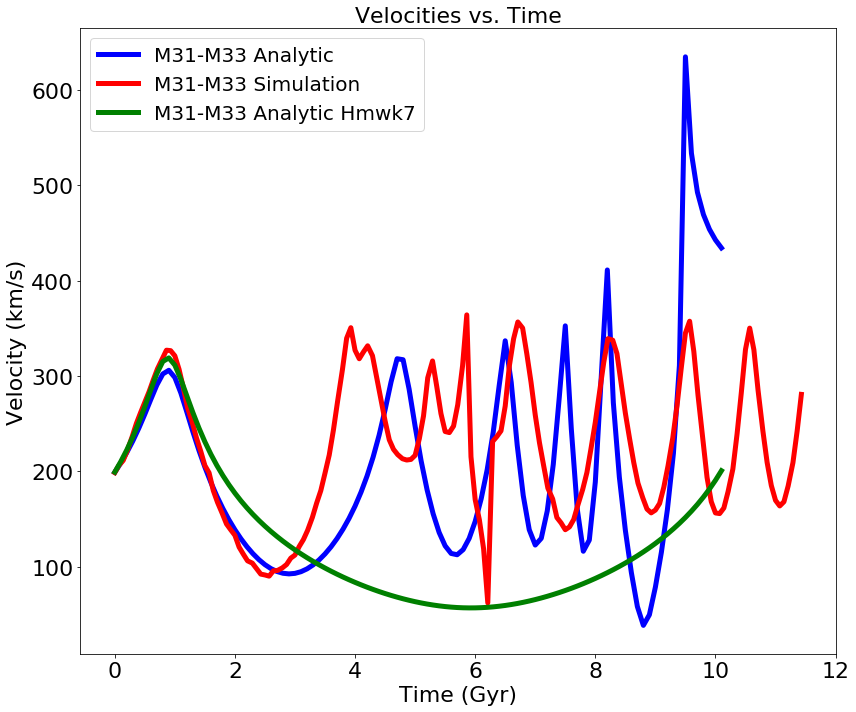

In [15]:
# Plot the orbital velocities of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(12, 10))

# Plot the analytical velocities of M31 and M33
ax.plot(M33Orbit['t'], M31_M33_V, 'b', lw=5, label='M31-M33 Analytic')

# Plot the simulated velocities of M31 and M33
ax.plot(M33SimOrbit['t'], M31_M33_SimV, 'r', lw=5, label='M31-M33 Simulation')

# Plot the simulated separation of M31 and M33 from Homework 7
ax.plot(M33Orbit_Hmwk7['t'], M31_M33_V_Hmwk7, 'g', lw=5, label='M31-M33 Analytic Hmwk7')


# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Velocity (km/s)', fontsize=22)
ax.set_title("Velocities vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_M33_V.pdf')